In [40]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt

In [41]:
#directories
dataset_dir = 'datasets/cyl_field_dataset'
output_dir ="output"
g_matrix_filename = "G_cyl_field.npy"

In [42]:
#store the computed images on disk
save_output = False

In [43]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [44]:
imgs = load_images_from_folder(dataset_dir)
n = len(imgs)

In [45]:
G = np.load(os.path.join(output_dir,g_matrix_filename))

In [46]:
i=0
j=0
print(G[3*i:3*(i+1),3*j:3*(j+1)])

[[-5. -0. -0.]
 [-0. -5. -0.]
 [-0. -0. -5.]]


In [47]:
u,d,vh = np.linalg.svd(G)

In [48]:
v = vh.transpose()

In [49]:
print(G.shape, u.shape, d.shape, vh.shape)

(24, 24) (24, 24) (24,) (24, 24)


In [50]:
#u: left eigenvectors
#d: eigenvalues
#v: right eigenvectors

In [51]:
print(d)

[2.27503856e+03 2.24936392e+03 1.08764554e+03 1.08316082e+03
 6.55981992e+02 6.37469957e+02 2.49226845e+02 1.02380069e+02
 5.64773688e+00 4.27442280e+00 4.00782024e+00 3.98948710e+00
 3.56571873e+00 1.98827541e+00 1.38629245e+00 7.51729283e-01
 8.32926860e-02 3.23219329e-02 2.76086003e-02 7.76775487e-03
 4.60998765e-03 6.21809817e-04 6.43695146e-06 4.68453631e-07]


In [52]:
np.argsort(d)

array([23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,
        6,  5,  4,  3,  2,  1,  0], dtype=int64)

In [53]:
# then find the three right singular vectors associated
# with the 3 smallest singular value, so the last 3 columns

In [54]:
# u_hat = np.dot( np.diag(np.sqrt(d)), v)[:,[-1,-2,-3]]

In [55]:
u_hat = v[:,[-1,-2,-3]]

In [56]:
u_hat.shape

(24, 3)

In [57]:
np.dot( u_hat.transpose(), u_hat)

array([[ 1.00000000e+00, -1.63064007e-16,  1.42247325e-16],
       [-1.63064007e-16,  1.00000000e+00,  4.85722573e-17],
       [ 1.42247325e-16,  4.85722573e-17,  1.00000000e+00]])

In [58]:
def get_states(x):
    x_small = x.transpose()
    res = [ x_small[:,i*3:(i+1)*3].transpose() for i in range(x_small.shape[1]//3)]
    return res

In [59]:
U = get_states(u_hat)

In [60]:
def stitch_images(U, imgs, idx_ref, num):
    
    H = [np.dot(U[i],np.linalg.inv(U[idx_ref])) for i in range(num)]
    
    size =  [10000,5000]
    
    stitch = np.zeros(size + [3], dtype=int)
    
    for i in range(num):
        
#          ## translate
#         (Height, Width, _) = imgs[i].shape

#         # Taking the matrix of initial coordinates of the corners of the secondary image
#         # Stored in the following format: [[x1, x2, x3, x4], [y1, y2, y3, y4], [1, 1, 1, 1]]
#         # Where (xt, yt) is the coordinate of the i th corner of the image. 
#         InitialMatrix = np.array([[0, Width - 1, Width - 1, 0],
#                                   [0, 0, Height - 1, Height - 1],
#                                   [1, 1, 1, 1]])

#         # Finding the final coordinates of the corners of the image after transformation.
#         # NOTE: Here, the coordinates of the corners of the frame may go out of the 
#         # frame(negative values). We will correct this afterwards by updating the 
#         # homography matrix accordingly.
#         FinalMatrix = np.dot(H[i], InitialMatrix)

#         [x, y, c] = FinalMatrix
#         x = np.divide(x, c)
#         y = np.divide(y, c)

#         min_x = min(x)
#         min_y = min(y)

#         t = [-min_x,-min_y]
#         Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate
        
#         # debug
#         #print(InitialMatrix,FinalMatrix)

#         H_proj = np.dot(Ht,H)

        ## apply h
        
        img_proj = cv.warpPerspective(imgs[i], np.linalg.inv(H[i]), size[::-1])
        
        #plt.imshow(img_proj[:1000,:1000],),plt.show()
        
        stitch = np.maximum(stitch,img_proj)
    
    return H, stitch

In [61]:
_,stitch = stitch_images(U, imgs, 1, 3)

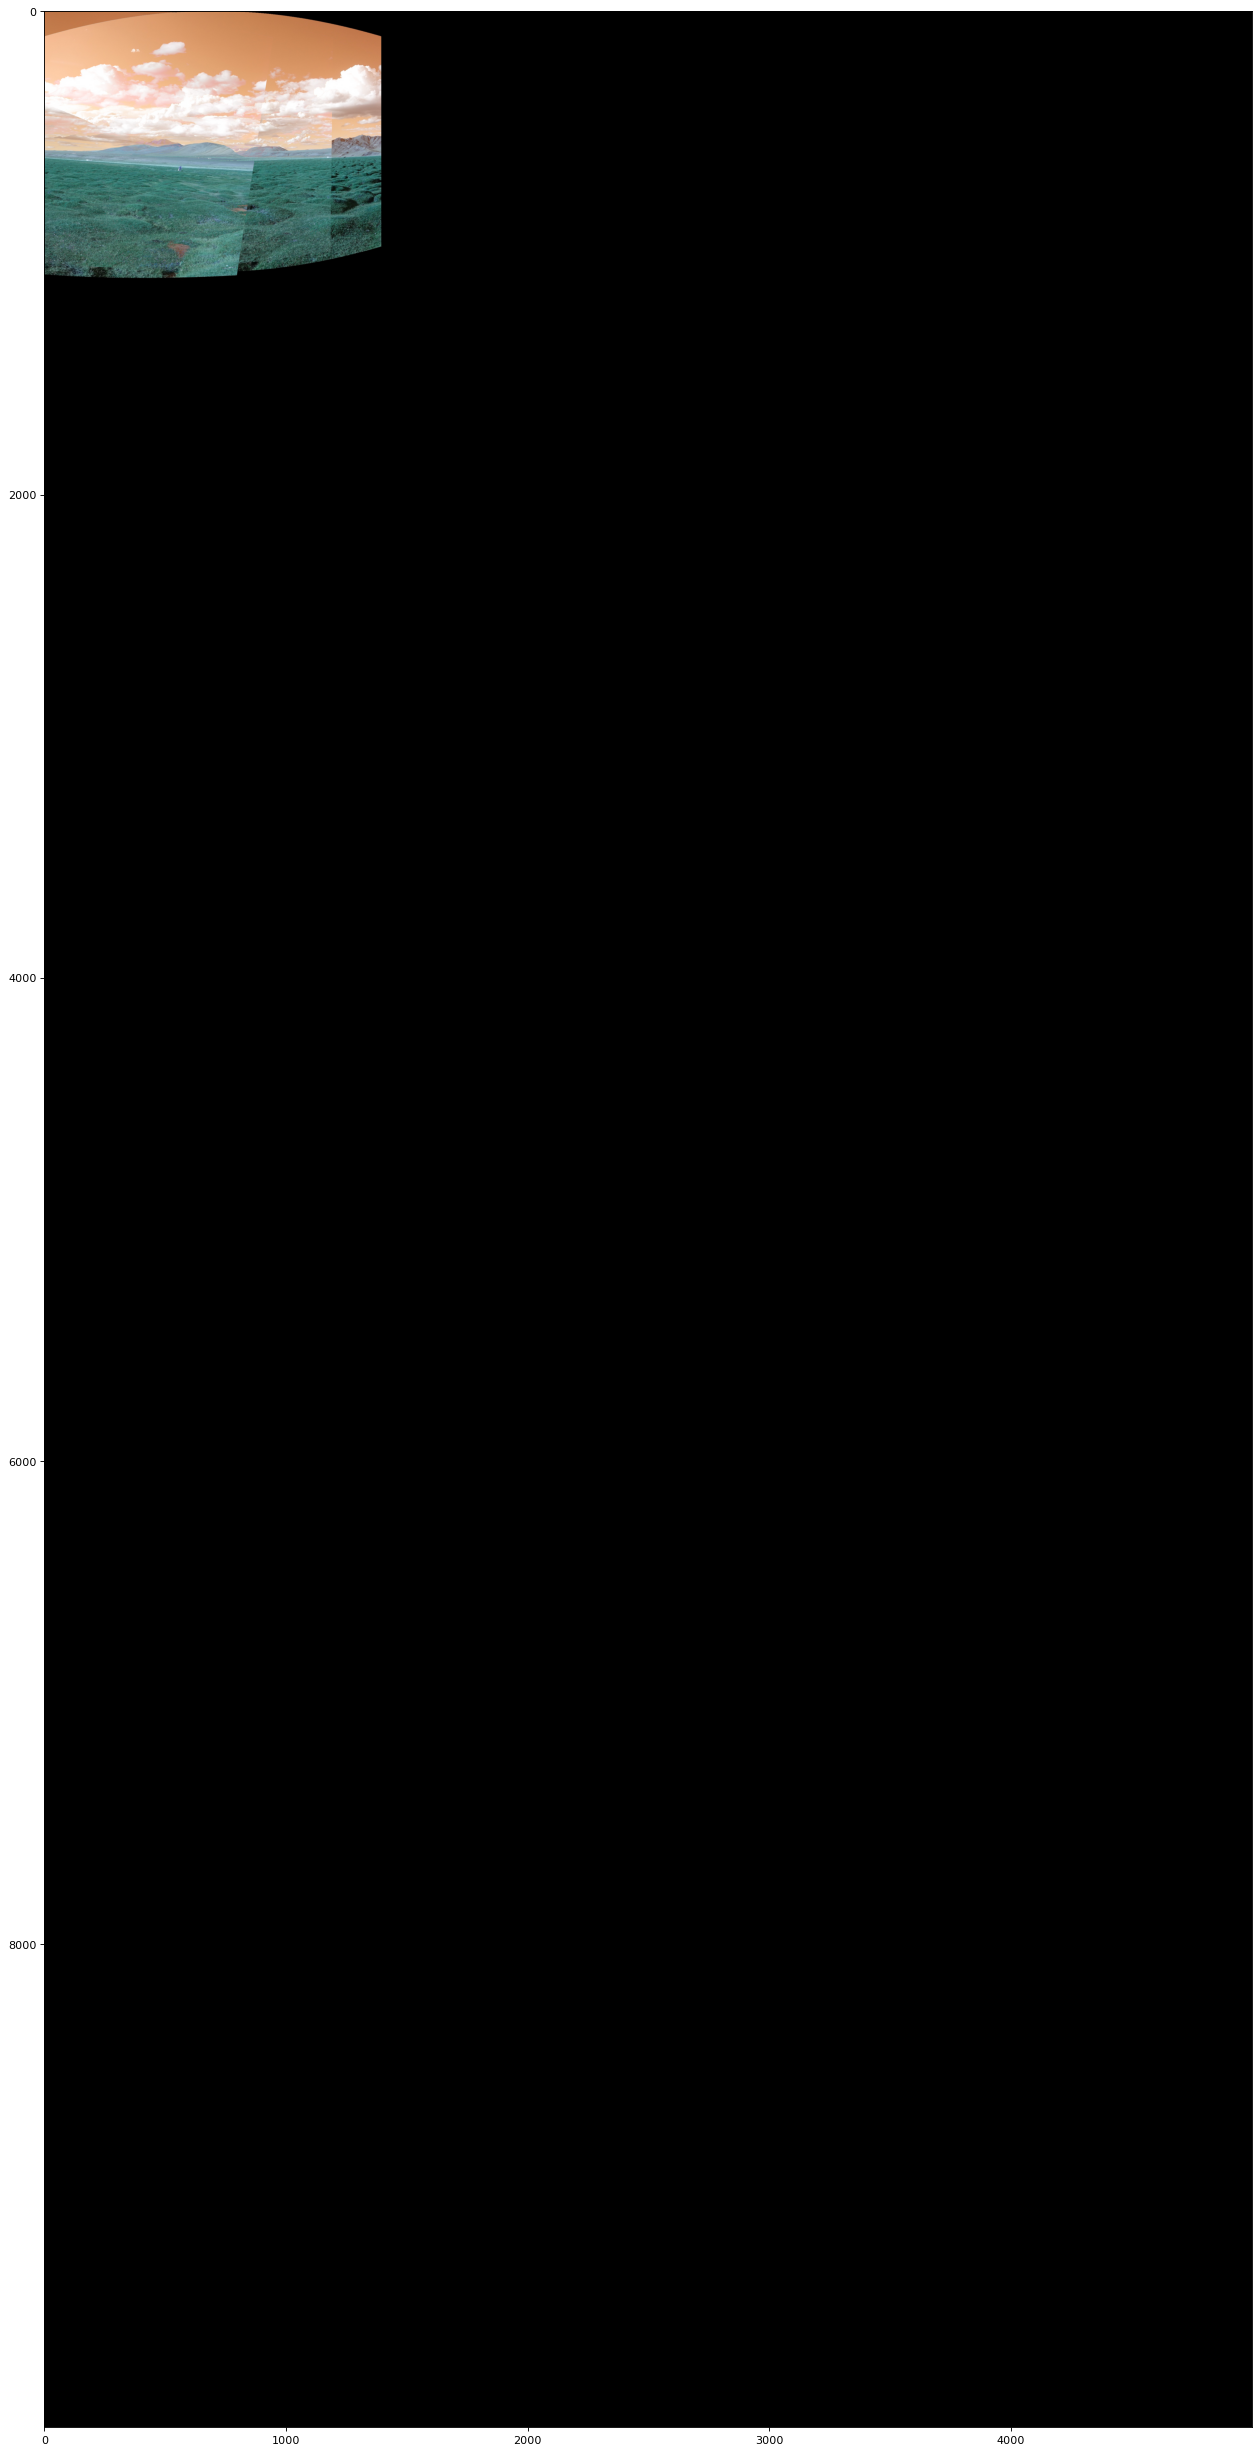

(<matplotlib.image.AxesImage at 0x16501964ee0>, None)

In [62]:
from matplotlib.pyplot import figure

figure(figsize=(40, 40), dpi=80)
plt.imshow(stitch,),plt.show()

In [24]:
i1 = 5
i2 = 4

im_1 = cv.warpPerspective(imgs[i1], np.eye(3), [10000,5000])
im_2 = cv.warpPerspective(imgs[i2], np.linalg.inv(G[(i2)*3:(i2+1)*3,(i1)*3:(i1+1)*3]), [10000,5000])

In [25]:
stitch = np.maximum(im_1,im_2)

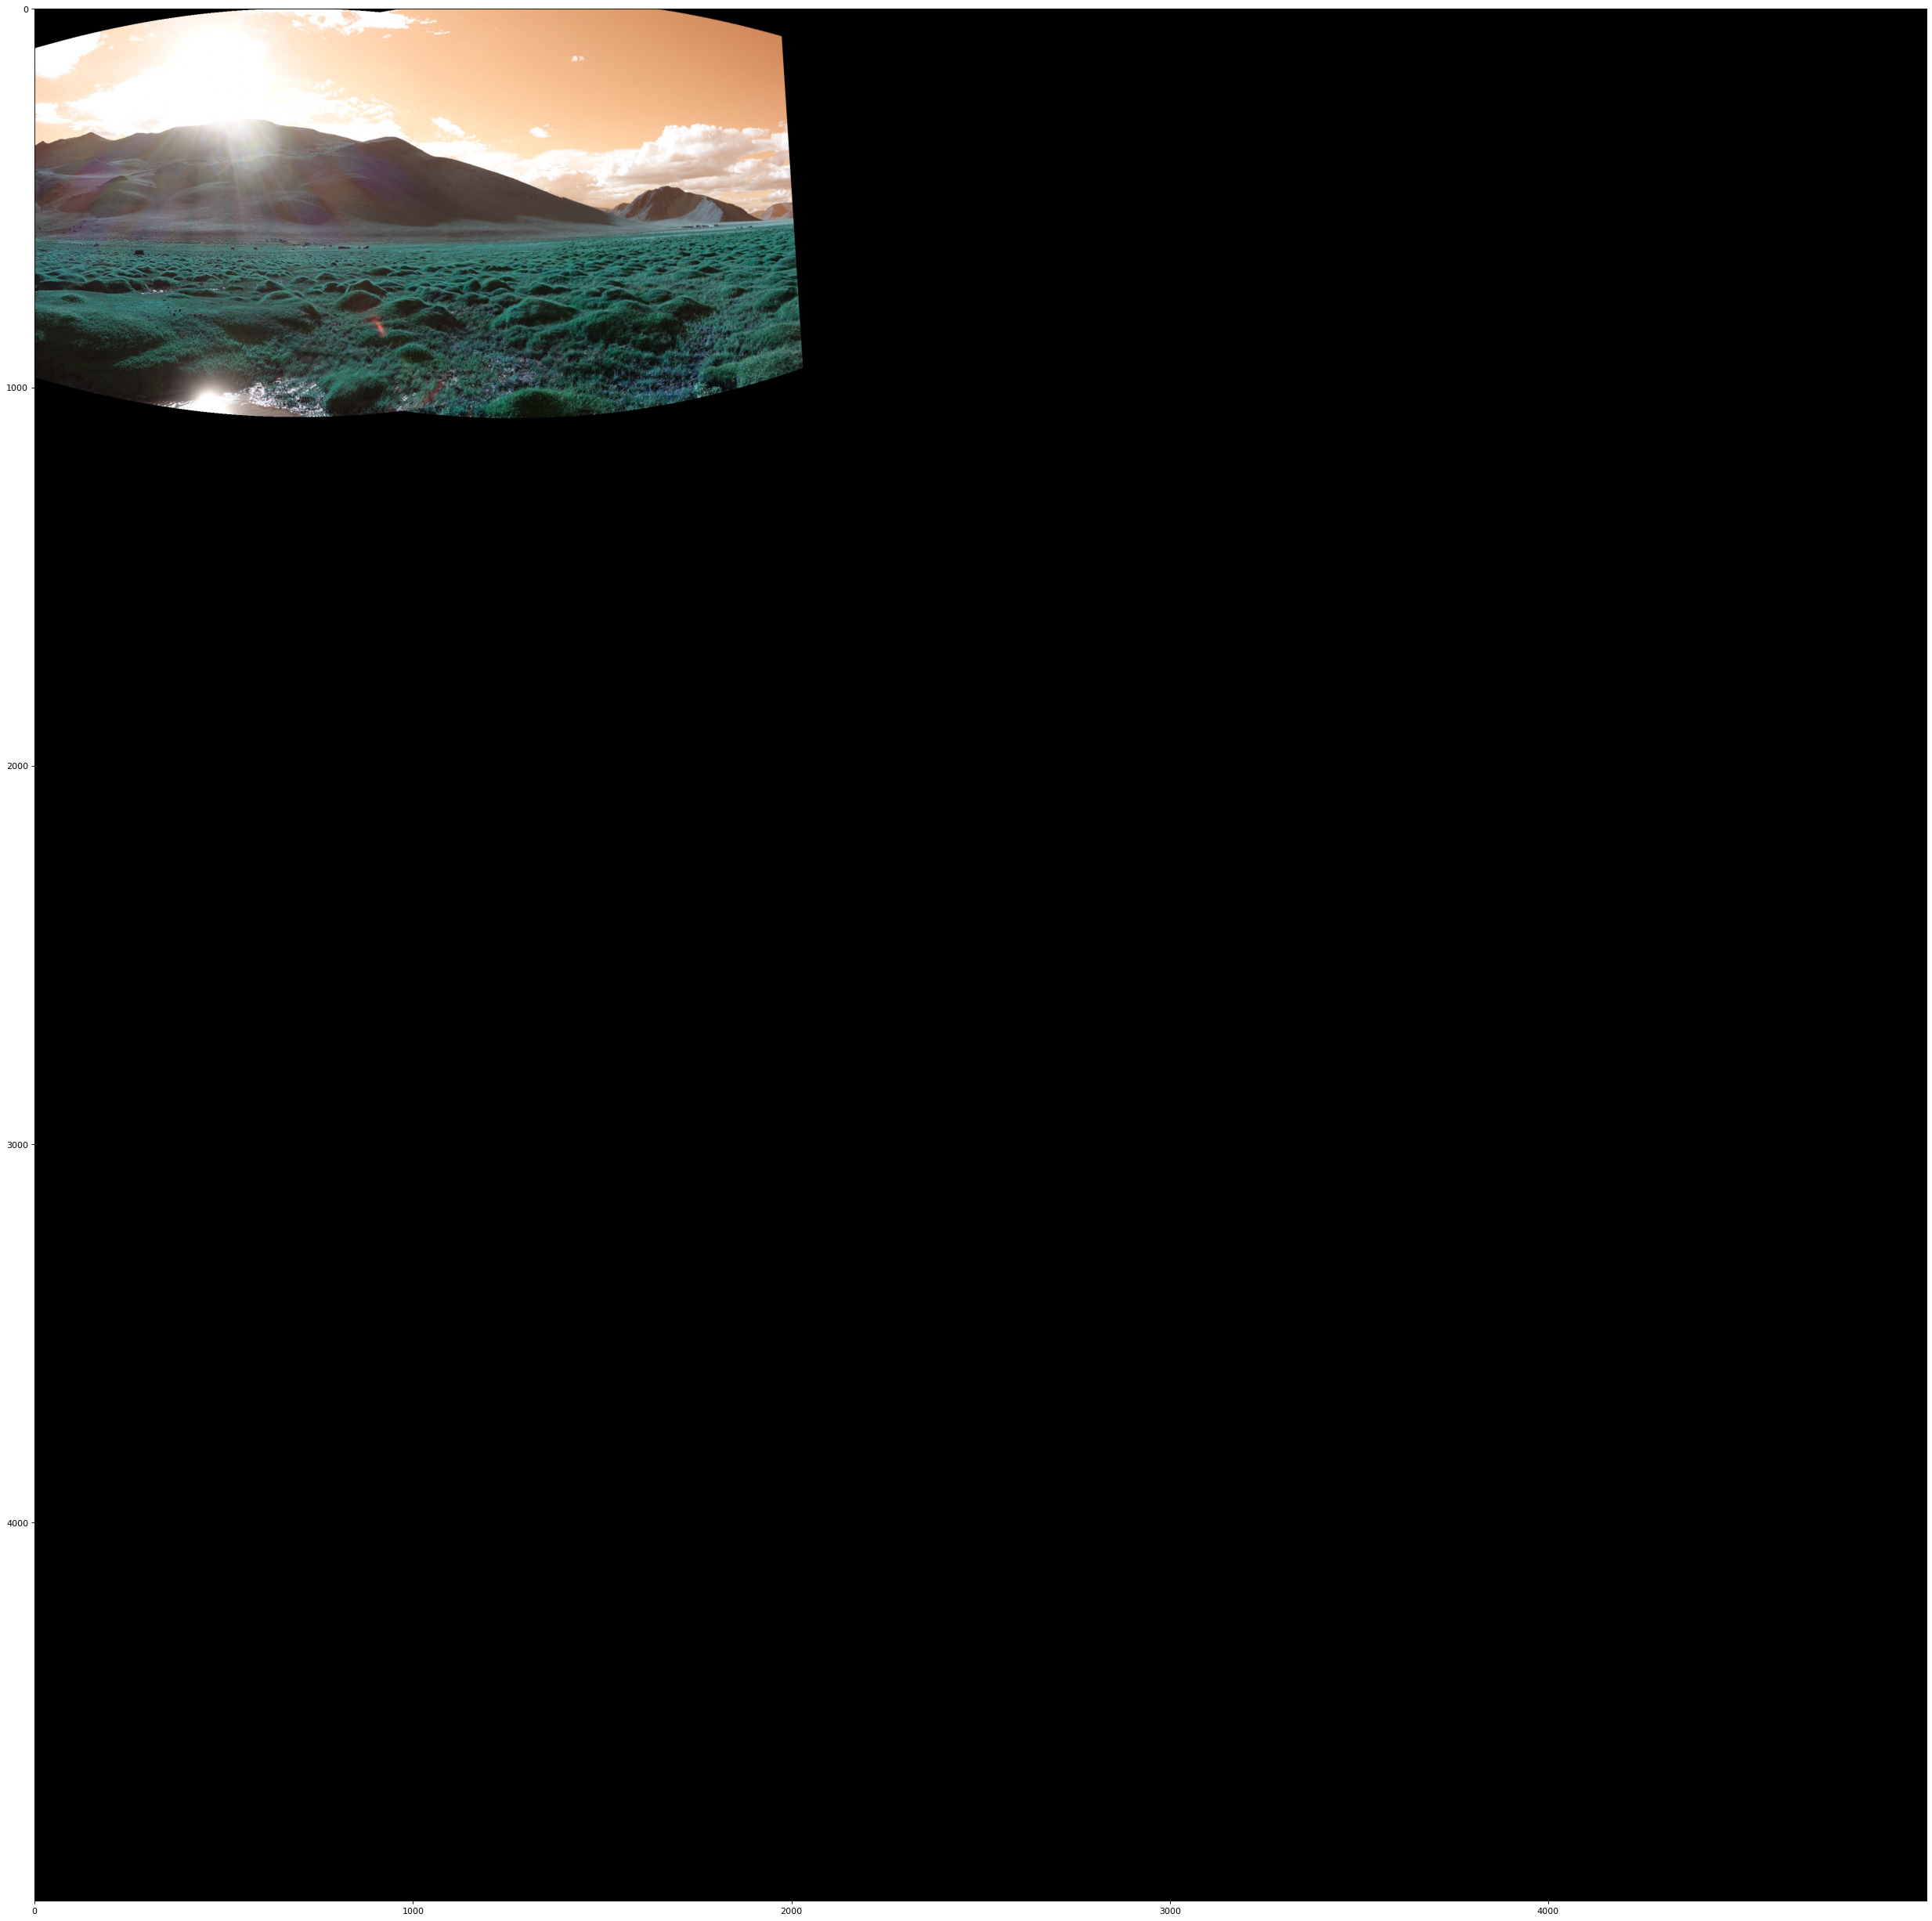

(<matplotlib.image.AxesImage at 0x1d8da575d90>, None)

In [26]:
from matplotlib.pyplot import figure
figure(figsize=(40, 40), dpi=80)
plt.imshow(stitch[:10000,:5000],),plt.show()